In [1]:
import tensorflow as tf
import pickle
import numpy as np
import math as math
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

C:\tools\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
def create_model(channel, activation='relu', dropout=0.0, optimizer='adam', neurons=64): 
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(neurons, kernel_size=3, padding='same', activation=activation, input_shape=(32, 32, channel)))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation=activation))
    model.add(tf.keras.layers.Dense(256, activation=activation))
    model.add(tf.keras.layers.Dense(43, activation='softmax'))
  
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

    model.summary()

    return model

In [3]:
def generate_plots(directory, file, model_history, epochs):
    """
    A method that takes the model history of a trained model and plots its:
    1. Training accuracy
    2. Training loss
    3. Validation accuracy
    4. Validation loss
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']


    plt.figure(1)
    plt.suptitle('Accuracy learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.plot(acc, label='training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.legend(loc="lower right")
    plt.savefig("{}/accuracy_{}.png".format(directory, file), dpi=300)

    plt.figure(2)
    plt.suptitle('Loss learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.plot(loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.legend(loc="upper right")
    plt.savefig("{}/loss_{}.png".format(directory, file), dpi=300)

In [4]:
# def create_model2(image_shape=(32, 32, 3)):

#     vgg16 = tf.keras.applications.VGG16(include_top=True,
#                                         weights=None,
#                                         input_shape=image_shape,
#                                         classes=43)

#     model = tf.keras.Sequential()

#     # Freeze the layers
#     for layer in model.layers:
#         layer.trainable = False
    
#     model.add(vgg16)
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(512, activation="relu"))
#     model.add(tf.keras.layers.Dropout(0.4))
#     model.add(tf.keras.layers.Dense(512, activation="relu"))
#     model.add(tf.keras.layers.Dropout(0.4))
#     model.add(tf.keras.layers.Dense(256, activation="relu"))
#     model.add(tf.keras.layers.Dropout(0.4))

#     # Add 'softmax' instead of earlier 'prediction' layer.
#     model.add(tf.keras.layers.Dense(43, activation='softmax'))

#     model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
#                 optimizer=tf.keras.optimizers.Adam(), 
#                 metrics=['accuracy'])

#     model.summary()

#     return model

In [5]:
# Variables
EPOCHS = 15
BATCH_SIZE = 512
file = 3

In [6]:
if file==0 or file==1 or file==2 or file==3:
    channel = 3
else:
    channel = 1

# Opening file for reading in binary mode
with open('../data/data{}.pickle'.format(file), 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

In [7]:
y_train = data['y_train']
y_val = data['y_validation']
y_test = data['y_test']

In [8]:
# Making channels come at the end
X_train = data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
X_val = data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
X_test = data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

In [9]:
# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else:
        print(i + ':', j.shape)

labels: 43
y_validation: (4410,)
x_test: (12630, 32, 32, 3)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_test: (12630,)
y_train: (86989,)


In [10]:
# Initialize the directories
save_model = "saved_models"
plot_dir = "plots"
results_dir = "results"

root_dir = os.path.abspath('./')
model_save_dir = os.path.join(root_dir, save_model)
plot_save_dir = os.path.join(root_dir, plot_dir)
results_save_dir = os.path.join(root_dir, results_dir)


os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(plot_save_dir, exist_ok=True)
os.makedirs(results_save_dir, exist_ok=True)


model = create_model(channel=channel, activation="tanh", dropout=0.3, optimizer="adam", neurons=128)

# For enabling early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('{}/best_model_data{}.h5'.format(model_save_dir, file), monitor='val_loss', mode='main', save_best_only=True, verbose=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
____

In [11]:
with tf.device('/device:GPU:0'):

    # Random Rotations
    # define data preparation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, brightness_range=[0.3, 0.6])
    datagen.fit(X_train)
    
    
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                      validation_data=(X_val, y_val),
                                      steps_per_epoch=len(X_train) // BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[es, mc])
            

Epoch 1/15
168/169 [============================>.] - ETA: 0s - loss: 3.7998 - acc: 0.0231
Epoch 00001: val_loss improved from inf to 3.77681, saving model to C:\Users\knarang\Documents\F3\TrafficSignCNN\step 7\saved_models/best_model_data3.h5
169/169 [==============================] - 50s 297ms/step - loss: 3.7996 - acc: 0.0231 - val_loss: 3.7768 - val_acc: 0.0159
Epoch 2/15
168/169 [============================>.] - ETA: 0s - loss: 3.7794 - acc: 0.0228
Epoch 00002: val_loss did not improve from 3.77681
169/169 [==============================] - 50s 296ms/step - loss: 3.7795 - acc: 0.0228 - val_loss: 3.7814 - val_acc: 0.0245
Epoch 3/15
168/169 [============================>.] - ETA: 0s - loss: 3.7788 - acc: 0.0234
Epoch 00003: val_loss improved from 3.77681 to 3.77186, saving model to C:\Users\knarang\Documents\F3\TrafficSignCNN\step 7\saved_models/best_model_data3.h5
169/169 [==============================] - 51s 300ms/step - loss: 3.7787 - acc: 0.0234 - val_loss: 3.7719 - val_acc: 0

In [12]:
predictions = model.predict(X_test, batch_size=512)

y_pred = [np.argmax(prediction) for prediction in predictions]

acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average="macro")
rec = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

C:\tools\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\tools\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
f = open("{}/results_{}.txt".format(results_save_dir, file), "w+")
f.write("Accuracy: {}\n".format(acc))
f.write("Precision: {}\n".format(pre))
f.write("Recall: {}\n".format(rec))
f.write("F1 score: {}\n".format(f1))
f.close()

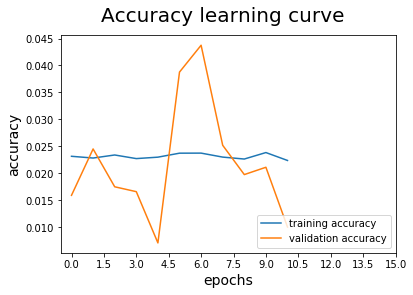

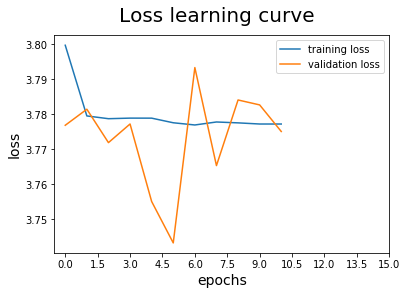

In [14]:
generate_plots(plot_save_dir, file, history, EPOCHS)

In [15]:
model.save('{}/best_model_data{}.h5'.format(model_save_dir, file)) 

# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
# new_model.summary()